Index(['Date', 'Date_Type', 'Age', 'Sex', 'Race', 'Ethnicity',
       'Residence_City', 'Residence_County', 'Residence_State', 'Injury_City',
       'Injury_County', 'Injury_State', 'Injury_Place',
       'Description_of_Injury', 'Death_City', 'Death_County', 'Death_State',
       'Location', 'Location_if_Other', 'Cause_of_Death', 'Manner_of_Death',
       'Other_Significant_Conditions', 'Heroin', 'Heroin_death_certificate_DC',
       'Cocaine', 'Fentanyl', 'Fentanyl_Analogue', 'Oxycodone', 'Oxymorphone',
       'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone',
       'Meth/Amphetamine', 'Amphet', 'Tramad', 'Hydromorphone',
       'Morphine_Not_Heroin', 'Xylazine', 'Gabapentin', 'Opiate_NOS',
       'Heroin/Morph/Codeine', 'Other_Opioid', 'Any_Opioid', 'Other',
       'ResidenceCityGeo', 'InjuryCityGeo', 'DeathCityGeo'],
      dtype='object')
         Date      Date_Type   Age     Sex   Race Ethnicity Residence_City   
0  05/29/2012  Date of death  37.0    Male  Black       NaN 

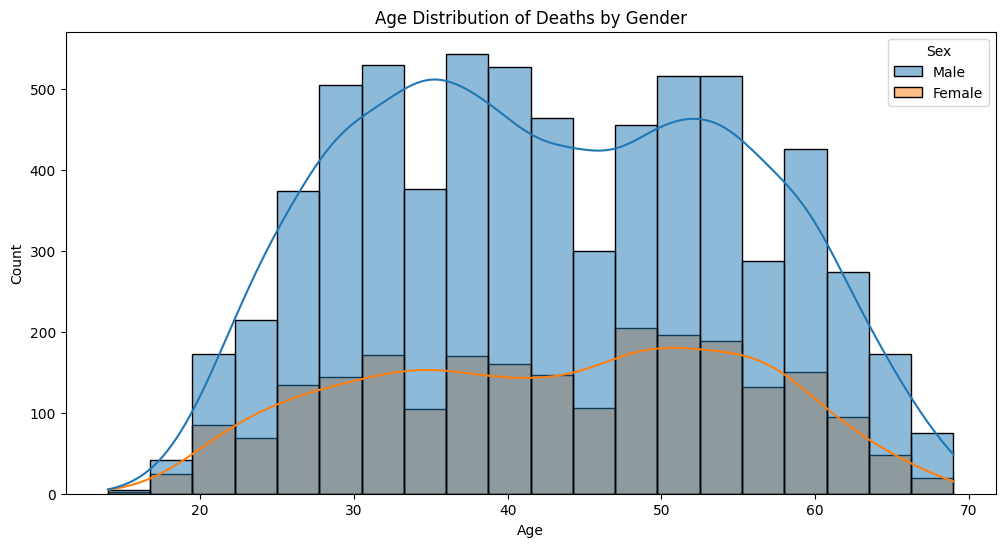

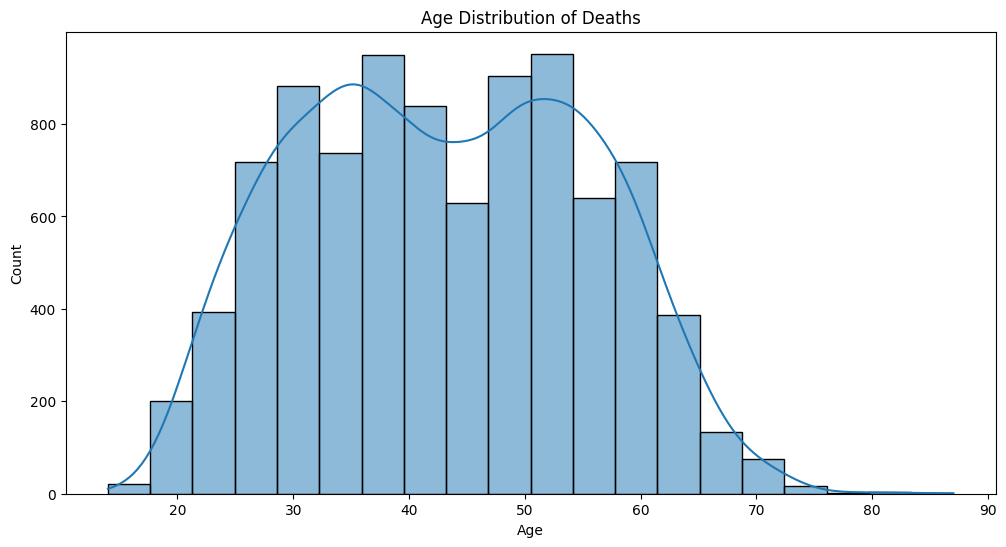

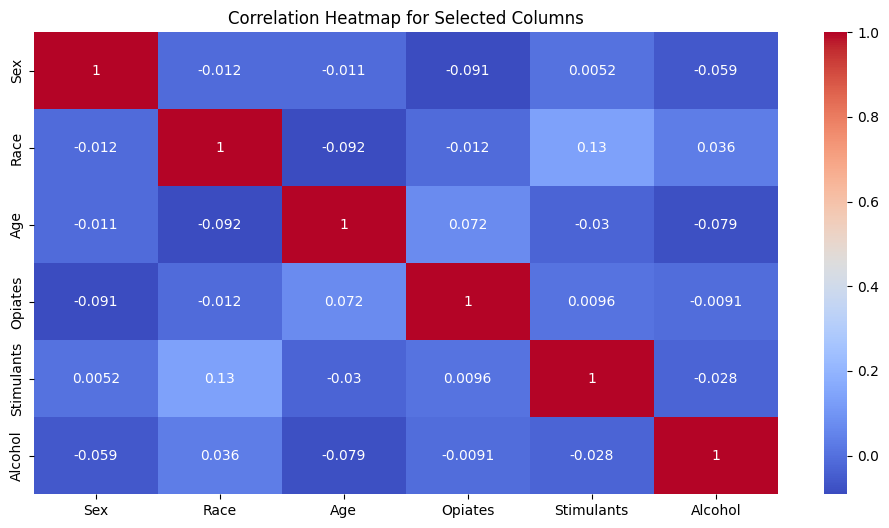

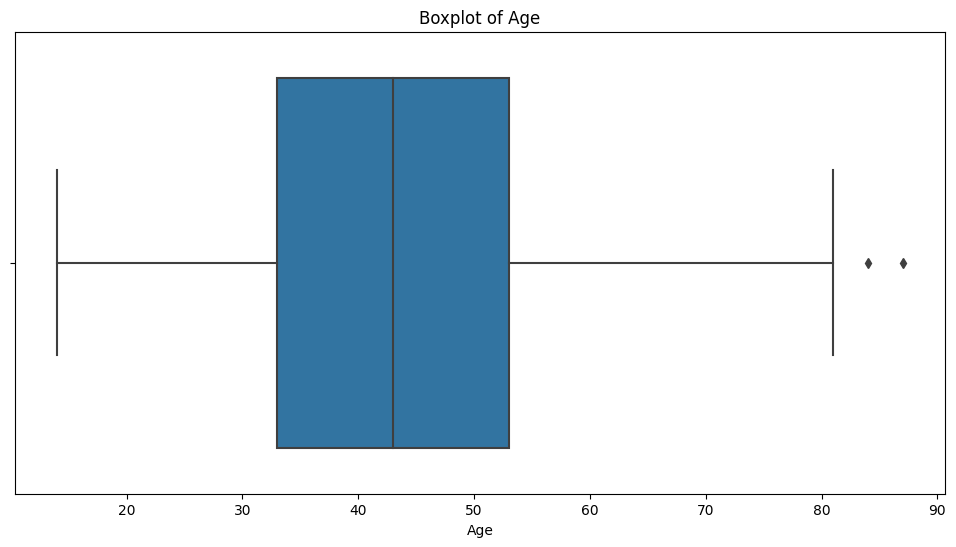

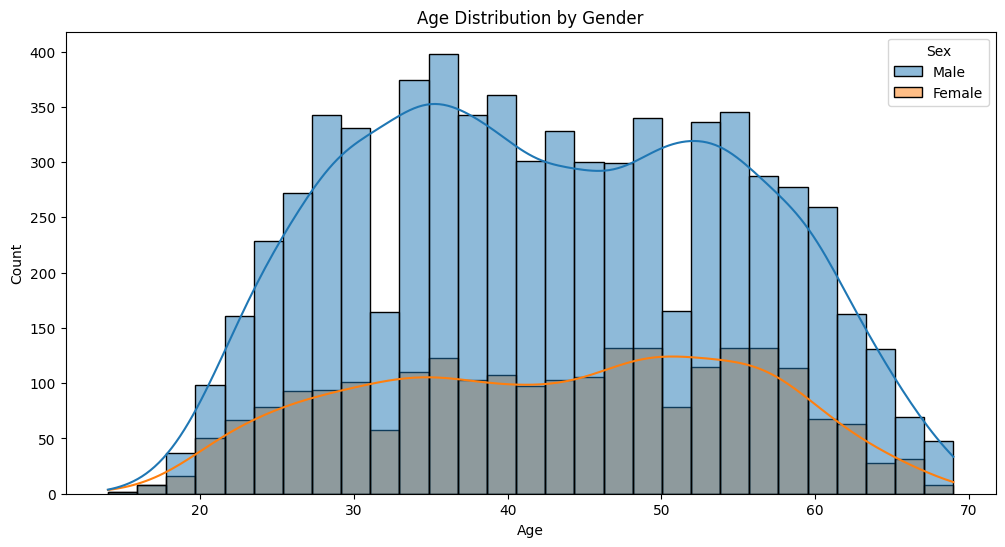

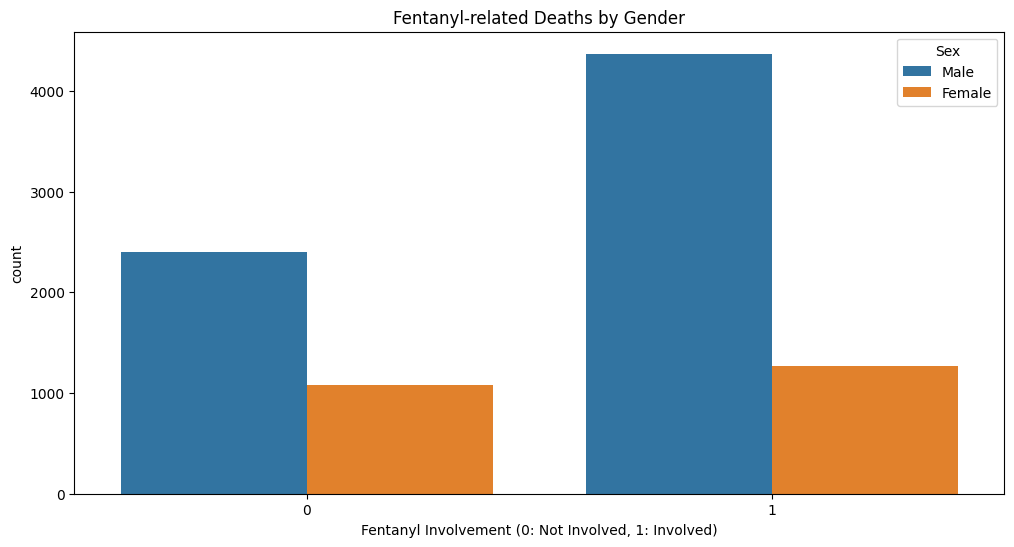

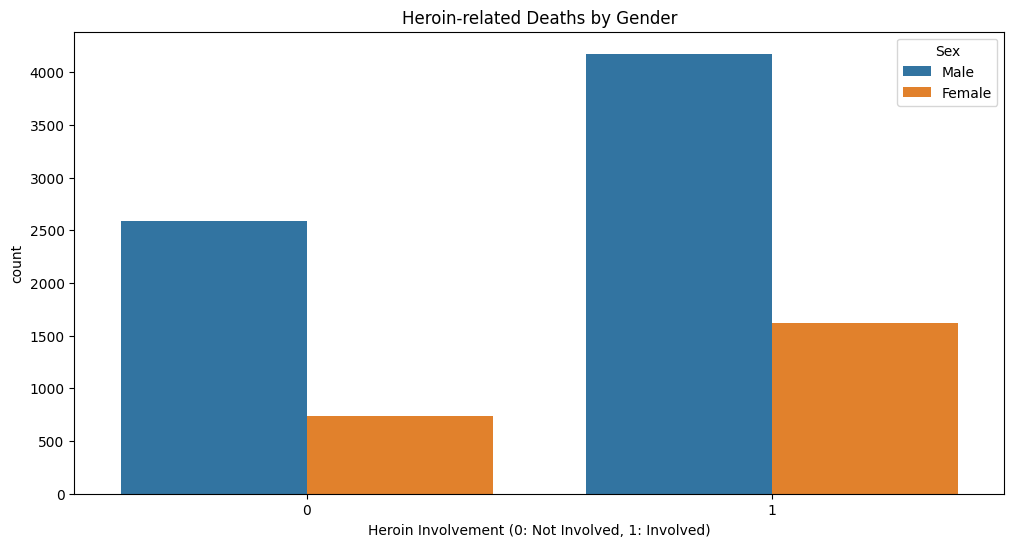

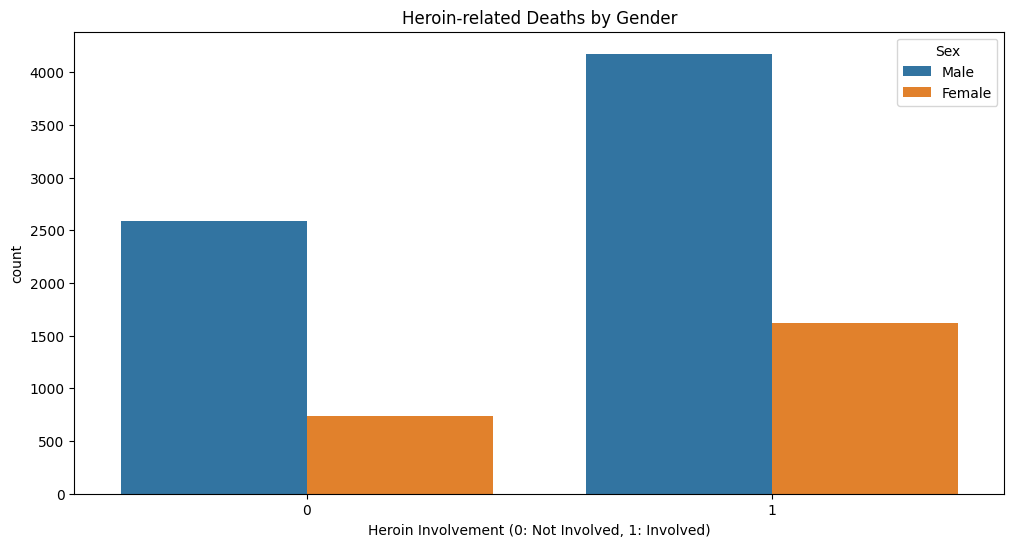

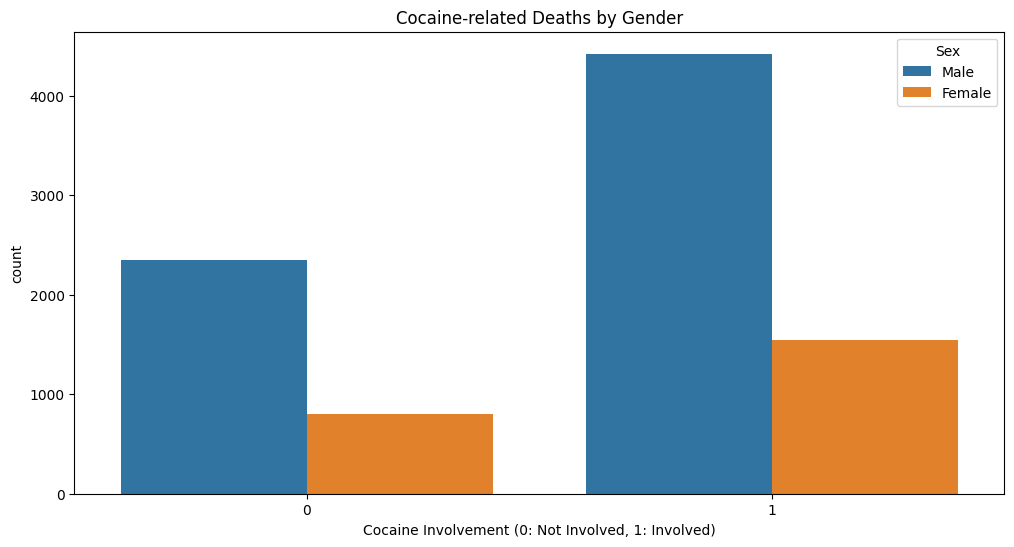

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
url = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print(df.columns)

# Preliminary data analysis
print(df.head())
print(df.info())

# Constraints: Identify any missing data
missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

# Convert 'Date' column to datetime format and extract the year
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Drop the original 'Date' column
df.drop(columns=['Date'], inplace=True)

# Convert non-numeric columns to numeric using label encoding
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Remove outliers based on age
age_outlier_threshold = df['Age'].quantile(0.99)
clean_df = df[df['Age'] <= age_outlier_threshold]

# Impute missing data
clean_df = clean_df.fillna('Unknown')

# Filter out rows with missing gender values
# Filter out rows with 2 value in the 'Sex' column
clean_df = clean_df[clean_df['Sex'] != 2]

# Create a dictionary to map numeric values to labels
gender_dict = {0: 'Female', 1: 'Male'}

# Replace numeric values with corresponding labels
clean_df['Sex'] = clean_df['Sex'].replace(gender_dict)

# Age Distribution of Deaths by Gender
plt.figure(figsize=(12, 6))
sns.histplot(data=clean_df, x='Age', hue='Sex', kde=True, bins=20)
plt.title('Age Distribution of Deaths by Gender')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Age Distribution of Deaths')
plt.show()

# Create 'Opiates', 'Stimulants', and 'Alcohol' columns
df['Opiates'] = df[['Fentanyl', 'Heroin', 'Methadone', 'Oxycodone', 'Oxymorphone','Hydrocodone']].sum(axis=1)
df['Stimulants'] = df[['Cocaine', 'Amphet']].sum(axis=1)
df['Alcohol'] = df['Ethanol']

# List of columns to include in the correlation heatmap
selected_columns = ['Sex', 'Race', 'Age', 'Opiates', 'Stimulants', 'Alcohol']

# Create a new DataFrame with only the selected columns
df_selected = df[selected_columns]

# Heatmap of Correlation
plt.figure(figsize=(12, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap for Selected Columns')
plt.show()

# Outlier Analysis: Detect and report any outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Age')
plt.title('Boxplot of Age')
plt.show()

# Preliminary Analysis: Investigate how features relate to each other
plt.figure(figsize=(12, 6))
sns.histplot(data=clean_df, x='Age', hue='Sex', kde=True)
plt.title('Age Distribution by Gender')
plt.show()

# Create a temporary DataFrame for plotting
temp_df = clean_df.copy()

# Adjust the Fentanyl values
temp_df['Fentanyl'] = temp_df['Fentanyl'].replace({0: 1, 3: 0})

# Fentanyl-related Deaths by Gender
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=temp_df, x='Fentanyl', hue='Sex')
plt.title('Fentanyl-related Deaths by Gender')
plt.xlabel('Fentanyl Involvement (0: Not Involved, 1: Involved)')
ax.set_xlim(-0.5, 1.5)  # Set x-axis limits to exclude the unwanted value (2)
plt.show()

# Heroin-related Deaths by Gender
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x='Heroin', hue='Sex')
plt.title('Heroin-related Deaths by Gender')
plt.xlabel('Heroin Involvement (0: Not Involved, 1: Involved)')
plt.show()


# Heroin-related Deaths by Gender
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x='Heroin', hue='Sex')
plt.title('Heroin-related Deaths by Gender')
plt.xlabel('Heroin Involvement (0: Not Involved, 1: Involved)')
plt.show()

# Cocaine-related Deaths by Gender
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x='Cocaine', hue='Sex')
plt.title('Cocaine-related Deaths by Gender')
plt.xlabel('Cocaine Involvement (0: Not Involved, 1: Involved)')
plt.show()


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create 'Opiates', 'Stimulants', and 'Alcohol' columns in clean_df
clean_df['Opiates'] = clean_df[['Fentanyl', 'Heroin', 'Methadone', 'Oxycodone', 'Oxymorphone','Hydrocodone']].sum(axis=1)
clean_df['Stimulants'] = clean_df[['Cocaine', 'Amphet']].sum(axis=1)
clean_df['Alcohol'] = clean_df['Ethanol']

# Convert 'Sex' column back to numeric values using label encoding
le = LabelEncoder()
clean_df['Sex'] = le.fit_transform(clean_df['Sex'].astype(str))

# Choose relevant features for clustering
features = ['Sex', 'Race', 'Age', 'Opiates', 'Stimulants', 'Alcohol']

# Create a new DataFrame with the selected features
cluster_df = clean_df[features]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# Determine the optimal number of clusters using the silhouette score
scores = []
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    scores.append(silhouette_avg)
    print(f'Silhouette score for {n_clusters} clusters: {silhouette_avg}')

optimal_clusters = np.argmax(scores) + 2
print(f'Optimal number of clusters: {optimal_clusters}')

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_data)
cluster_labels = kmeans.labels_

# Add the cluster labels to the original DataFrame
clean_df['Cluster'] = cluster_labels

# Choose the columns to display in the output
output_columns = ['Age', 'Sex', 'Race', 'Opiates', 'Stimulants', 'Alcohol']

# Analyze the clusters
cluster_analysis = clean_df.groupby('Cluster')[output_columns].mean()
print(cluster_analysis)

# The silhouette score indicates how well the clusters are separated and cohesive.
# A higher score is better, with a maximum value of 1.

# The optimal number of clusters is determined by the number of clusters with the highest silhouette score.

# The final output displays the centroids for each cluster.
# The centroids represent the mean values of the features for each cluster.

Silhouette score for 2 clusters: 0.22863092539002075
Silhouette score for 3 clusters: 0.26270662004748924
Silhouette score for 4 clusters: 0.27894673648612456
Silhouette score for 5 clusters: 0.27951202919812806
Silhouette score for 6 clusters: 0.25055197662044676
Silhouette score for 7 clusters: 0.2742794906144333
Silhouette score for 8 clusters: 0.28789232712541296
Silhouette score for 9 clusters: 0.29871572264590857
Silhouette score for 10 clusters: 0.30088888492828686
Optimal number of clusters: 10
               Age       Sex       Race   Opiates  Stimulants   Alcohol
Cluster                                                                
0        29.970611  1.000000  11.979118  5.497293    2.000000  2.000000
1        39.781561  0.986711  11.975083  4.928571    0.954319  2.000000
2        44.218150  1.000000  11.987784  5.557592    2.000000  0.999127
3        44.865132  0.000000  11.998904  7.239035    1.766447  1.792763
4        45.296029  0.000000   3.216606  5.837545    1.37906